In [1]:
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## Description des données :

# Chargement des données d'entrainement :

In [60]:
train=pd.read_csv('data/train.csv')

In [61]:
train.shape

(1460, 81)

In [62]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Premier modèle :

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [63]:
train.groupby('CentralAir').agg({'CentralAir':'count'})

,CentralAir
CentralAir,
N,95
Y,1365


## Sélection des champs :

In [118]:
def parse_model_0(X):
    target = X['SalePrice']
    to_dummy = ['MSSubClass','MSZoning','Street','RoofStyle']
    dummy_classes = []
    binary_classes=['CentralAir']
    numeric_features=['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt']
    to_numeric_features=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual']
    
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum],prefix=dum)
        for col in split_temp:
            X[col] = split_temp[col]
            dummy_classes+=[col]
        del X[dum]
    
    for bina in binary_classes:
        X[bina] = np.where(X[bina]=='Y',1,0)
    
    for to_num in to_numeric_features:
        X[to_num] = np.where(X[to_num]=='Ex',5,
                    np.where(X[to_num]=='Gd',4,
                    np.where(X[to_num]=='TA',3,
                    np.where(X[to_num]=='Fa',2,
                    np.where(X[to_num]=='Po',1,np.nan
                    )))))
    
    X = X[dummy_classes+binary_classes+numeric_features+to_numeric_features]
    return X,target

In [119]:
X,y=parse_model_0(train.copy())

## Scaling des données et traitement des valeurs manquantes :

In [123]:
scaler=StandardScaler()
scaler.fit(X)
X_fitted = scaler.transform(X)

In [125]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_fitted)
X_fitted_imputed = imp.transform(X_fitted)

## Application simple d'un SVR :

In [157]:
regr=SVR()

In [158]:
regr.fit(X_fitted_imputed,y)

SVR()

In [159]:
score = regr.score(X_fitted_imputed,y)
print("R-squared:", score)
print("MSE:", mean_squared_error(y, yfit))

R-squared: -0.04926270479029915
MSE: 6617478049.60419


In [148]:
yfit = regr.predict(X_fitted_imputed)

In [150]:
len(y)

1460

In [151]:
len(yfit)

1460

ValueError: x and y must be the same size

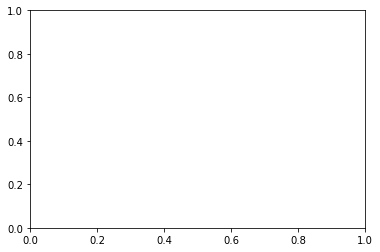

In [149]:
plt.scatter(X_fitted_imputed, y, s=5, color="blue", label="original")
plt.plot(X_fitted_imputed, yfit, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

## Test sur les données de test :

In [130]:
test = pd.read_csv('data/test.csv')

In [134]:
def parse_model_0_for_test(X):
    to_dummy = ['MSSubClass','MSZoning','Street','RoofStyle']
    dummy_classes = []
    binary_classes=['CentralAir']
    numeric_features=['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt']
    to_numeric_features=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual']
    
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum],prefix=dum)
        for col in split_temp:
            X[col] = split_temp[col]
            dummy_classes+=[col]
        del X[dum]
    
    for bina in binary_classes:
        X[bina] = np.where(X[bina]=='Y',1,0)
    
    for to_num in to_numeric_features:
        X[to_num] = np.where(X[to_num]=='Ex',5,
                    np.where(X[to_num]=='Gd',4,
                    np.where(X[to_num]=='TA',3,
                    np.where(X[to_num]=='Fa',2,
                    np.where(X[to_num]=='Po',1,np.nan
                    )))))
    
    X = X[dummy_classes+binary_classes+numeric_features+to_numeric_features]
    return X

In [139]:
X.columns

Index(['MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'RoofStyle_Flat',
       'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'CentralAir', 'LotFrontage',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'],
      dtype='object')

In [137]:
X_test.columns

Index(['MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'RoofStyle_Flat',
       'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'CentralAir', 'LotFrontage',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'],
      dtype='object')

In [140]:
X_test = parse_model_0_for_test(test.copy())
del X_test['MSSubClass_150']
X_test_fitted = scaler.transform(X_test)
X_test_fitted_imputed = imp.transform(X_test_fitted)

In [146]:
regr.predict(X_test_fitted_imputed)

array([162997.13146377, 163017.54371629, 163098.82041815, ...,
       163017.04799521, 163001.87004648, 163137.44839539])